# PPI-Network: Analysis Of The Graph Structure And The Effects Of Removing Edges

The following notebook is meant to showcase the effects removing edges have on the PPI-Graph structure that is used by GraphSynergy to predict synergy scores for drug combinations.
This can give us some insight into the connectivity, clustering, neighborhood information of the overall graph and how removing the edges might affect the performance of the GraphSynergy model.

To study the effects of edge removal we systematically remove edges throughout the graph and look at key metrics for the entirety of the graph as well as the nodes that are directly targeted by the model.

The metrics compared here are related to:
- **Node Degree Statistics**: How large are the neighborhoods and how much and rapidly do they shrink as edges are removed?
- **Clustering Information**: Does the graph consist of tightly connected clusters of nodes or is information spread out?
- **Neighborhood Information**: How does the connectivity and clustering of neighboring nodes change for the targeted proteins?


In [2]:
import os
import pandas as pd
import networkx as nx
from collections import defaultdict, Counter
import random
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

# Add random seed for reproducibility
random.seed(42)

In [3]:
# Load the datasets into memory as pandas dataframes

data_dir = "data/DrugCombDB"
# Only the first two columns from the ppi dataset is required as they contain the proteins that are connected
ppi_df = pd.read_excel(os.path.join(data_dir, 'protein-protein_network.xlsx'))
ppi_df = ppi_df[['protein_a', 'protein_b']]

cpi_df = pd.read_csv(os.path.join(data_dir, 'cell_protein.csv'))
dpi_df = pd.read_csv(os.path.join(data_dir, 'drug_protein.csv'))
drug_combo_df = pd.read_csv(os.path.join(data_dir, 'drug_combinations.csv'))

### Find Nodes Of Proteins Targeted By Drug Combinations (DrugComboDB)


- We create a list of proteins that are targeted by the drugs used in the drug combinations from DrugComboDB.
- This information will be used to specifically see the changes in the neighborhood of the proteins that are actually used to make predictions

In [4]:
# Find the unique drugs used in the combinations
used_drugs = list(set(drug_combo_df['drug1_db']) | set(drug_combo_df['drug2_db']))
# Find the proteins that those drugs target
drug_proteins = set(dpi_df.loc[dpi_df['drug'].isin(used_drugs), 'protein'])
# Find the cell lines that those drugs target
targeted_cells = set(drug_combo_df['cell'])
# Find the proteins that are in the targeted cell lines
targeted_cell_proteins = set(cpi_df.loc[cpi_df['cell'].isin(targeted_cells), 'protein'])
# Find the targeted proteins in the targeted cell lines
targeted_proteins = list(drug_proteins & targeted_cell_proteins)
print('Number of Targeted Proteins: ', len(targeted_proteins))

Number of Targeted Proteins:  819


### Removing Specified Fraction of Edges from The PPI-Graph 
- This is the main method used to alter the graph structure. *(Altered implementation from the original build_graph method)*
- Based on the defined ratio ([0; 0.9]) we randomly select edges throughout the graph

In [5]:
def build_randomized_graph(drop_ratio):
    tuples = [tuple(x) for x in ppi_df.values]
    remove_edges = random.sample(tuples, int(len(tuples)*drop_ratio))
    if drop_ratio == 0:
        assert remove_edges == [] or None, "The number of edges to be removed is not none despite drop_ratio being 0"
    g = nx.Graph()
    g.add_edges_from(tuples)
    g.remove_edges_from(remove_edges)
    return g

### Generate Graphs
- We generate and compare 10 PPI-Graphs
  - The first graph preserves all edges
  - The remaining graphs have between 10%-90% of edges removed, with 10 point intervals each

In [6]:
graphs = defaultdict()
drop_ratios = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for ratio in drop_ratios:
    graphs[ratio] = build_randomized_graph(ratio)

# Store the graphs and their labels
ppi_graphs = list(graphs.values())
labels = [f"{100*x}% Dropped" for x in list(graphs.keys())]

## Node Types and Frequencies

- Here we look at the types of nodes that are present in the graph and how frequently they appear as edges are removed
- In particular, we look at how rapid isolated nodes are formed as edges are removed

### Implications:
- As edges keep being removed, the graph becomes fragmented and nodes start to become isolated
- This could lead to information not being accessible for GraphSynergy to learn about the local PPIs and aggregate enough information

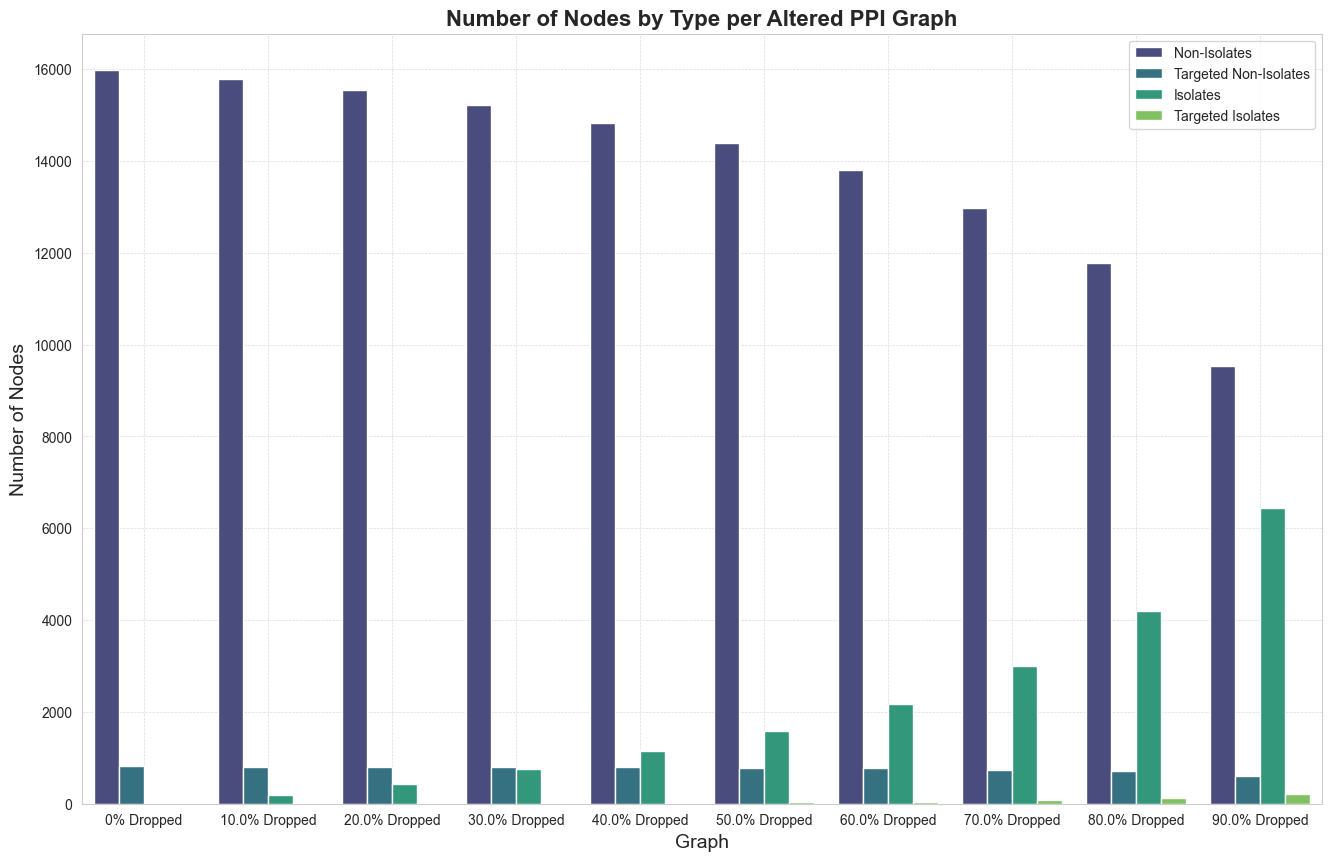

In [7]:
# Number of regular nodes
n_nodes = []
# Number of isolated nodes (isolates)
n_isolates = []
# Number of isolates that are targeted by the drug combinations
n_targeted_isolates = []
# Number of regular nodes that are targeted
n_targeted_non_isolates = []

# Create DataFrame containing the counts for each node type for each graph
for graph in ppi_graphs:
    isolates = list(nx.isolates(graph))
    non_isolates = [node for node, degree in graph.degree() if degree > 0]
    targeted_isolates = [node for node in targeted_proteins if node in isolates]
    targeted_non_isolates = [node for node in targeted_proteins if node in non_isolates]
    
    n_targeted_non_isolates.append(len(targeted_non_isolates))
    n_targeted_isolates.append(len(targeted_isolates))
    n_nodes.append(len(non_isolates))
    n_isolates.append(len(isolates))
    
graph_ratio = {
    "Graph": labels,
    "Non-Isolates": n_nodes,
    "Targeted Non-Isolates": n_targeted_non_isolates,
    "Isolates": n_isolates,
    "Targeted Isolates": n_targeted_isolates
}

ratio_df = pd.DataFrame(graph_ratio)
# Melted data frame to make plotting easier
melted_ratio_df = ratio_df.melt(id_vars='Graph', var_name="Node Type", value_name="Count")

# Plot the counts for each graph
plt.figure(figsize=(16, 10))
sns.barplot(data=melted_ratio_df, x="Graph", y="Count", hue="Node Type", palette="viridis")
plt.xlabel("Graph", fontsize=14)
plt.ylabel("Number of Nodes", fontsize=14)
plt.title("Number of Nodes by Type per Altered PPI Graph", fontsize=16, fontweight='bold')
plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend()

# Show plot
plt.show()

## Node Degree Distributions For Targeted Nodes

- **Degree**: Number of neighbors a node has
- Here we look at the number of neighbors the targeted nodes have depending on the number of randomly removed edges
- This gives us more insight into how fast neighborhoods shrink and how well the network remains connected as edges are removed

### Implications:

- The implications from before are valid here too
- Only a small fraction of nodes from the PPI-Graph is relevant for GraphSynergy
    - Likelihood of edges not related to targeted nodes being removed first is high --> Information is retained for GraphSynergy

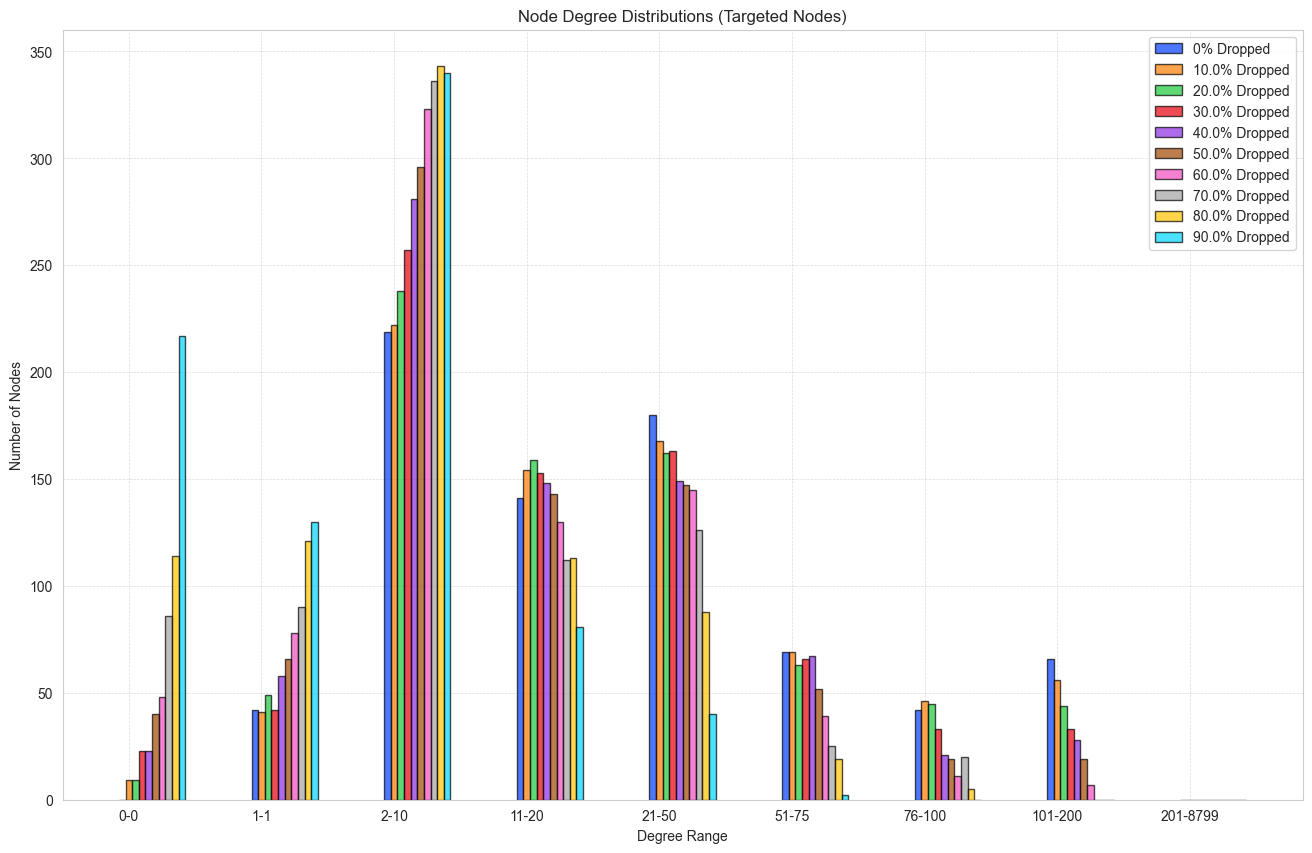

In [15]:
'''
Calculate the Degree Frequencies for Targeted Proteins (Plot Template Generated Using ChatGPT)
'''
colors = sns.color_palette("bright", n_colors=len(ppi_graphs))

# Plot the degree distribution as a bar plot
bin_edges = [0, 1, 2, 11, 21, 51, 76, 101, 201, max(len(nx.degree_histogram(ppi_graphs[0])), 201)]
bin_labels = [f"{bin_edges[i]}-{bin_edges[i+1]-1}" for i in range(len(bin_edges)-1)]
bar_width = 0.05

plt.figure(figsize=(16, 10))

# Offset positions for side-by-side bars
x_positions = np.arange(len(bin_labels))

for i, G in enumerate(ppi_graphs):
    # Generate the degree frequencies for targeted nodes
    degree_counts = Counter([G.degree(node) for node in targeted_proteins])
    
    # Aggregate counts within each bin
    binned_counts = []
    for j in range(len(bin_edges) - 1):
        start, end = bin_edges[j], bin_edges[j+1]
        count = sum(degree_counts[d] for d in range(start, min(end, len(degree_counts))))
        binned_counts.append(count)
    
    # Plot the binned degree distribution with offset bars
    plt.bar(x_positions + i * bar_width, binned_counts, color=colors[i], edgecolor='black', 
            width=bar_width, label=labels[i], alpha=0.7)

# Set x-ticks to be at the center of the grouped bars
plt.xticks(x_positions + bar_width, bin_labels)

# Labels and title
plt.xlabel("Degree Range")
plt.ylabel("Number of Nodes")
plt.title("Node Degree Distributions (Targeted Nodes)")
plt.legend()

plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

## Clustering Coefficients
- Measures the extent to which the nodes tend to form-up in tightly connected clusters
- Shows how likely a nodes neighbors are also connected to each other
- Scale between [0: 1], where 0 means none of the neighbors are connected to each other and 1 means all the nodes neighbors are also connected to each other
- **Local Clustering Coefficient:** Looks at the clustering of individual nodes
- **Global Clustering Coefficient:** Average of local clustering coefficients

### Implications:
- High clustering coefficient: Depending on the number of aggregations, the model might aggregate the same node information repeatedly
    - The model might put too much emphasis on localized protein interactions and fail to generalize to drug combinations targeting larger areas in the cell lines
- Low Clustering Coefficient: Sparsely connected neighborhoods, the model might have difficulties aggregating enough information about local protein structures
    - The model might become less accurate as it struggles to understand local protein interactions
 

### Global Clustering Coefficients

In [9]:
global_clustering = {
    "Graph": labels,
    "Global Clustering Coefficient": [nx.average_clustering(graph) for graph in ppi_graphs],
}

ct_df = pd.DataFrame(global_clustering)
print(ct_df)

           Graph  Global Clustering Coefficient
0     0% Dropped                       0.202506
1  10.0% Dropped                       0.176948
2  20.0% Dropped                       0.145269
3  30.0% Dropped                       0.129469
4  40.0% Dropped                       0.100620
5  50.0% Dropped                       0.078317
6  60.0% Dropped                       0.056738
7  70.0% Dropped                       0.034287
8  80.0% Dropped                       0.019486
9  90.0% Dropped                       0.005912


In [10]:
# Compute local clustering coefficients 
clustering_data = []
for label, graph in zip(labels, ppi_graphs): # Loop generated by ChatGPT
    local_clustering_coeffs = list(nx.clustering(graph).values())
    for coeff in local_clustering_coeffs:
        clustering_data.append({"Graph": label, "Local Clustering Coefficient": coeff})

clustering_df = pd.DataFrame(clustering_data)

### Distribution of Local Clustering Coefficients For All Nodes

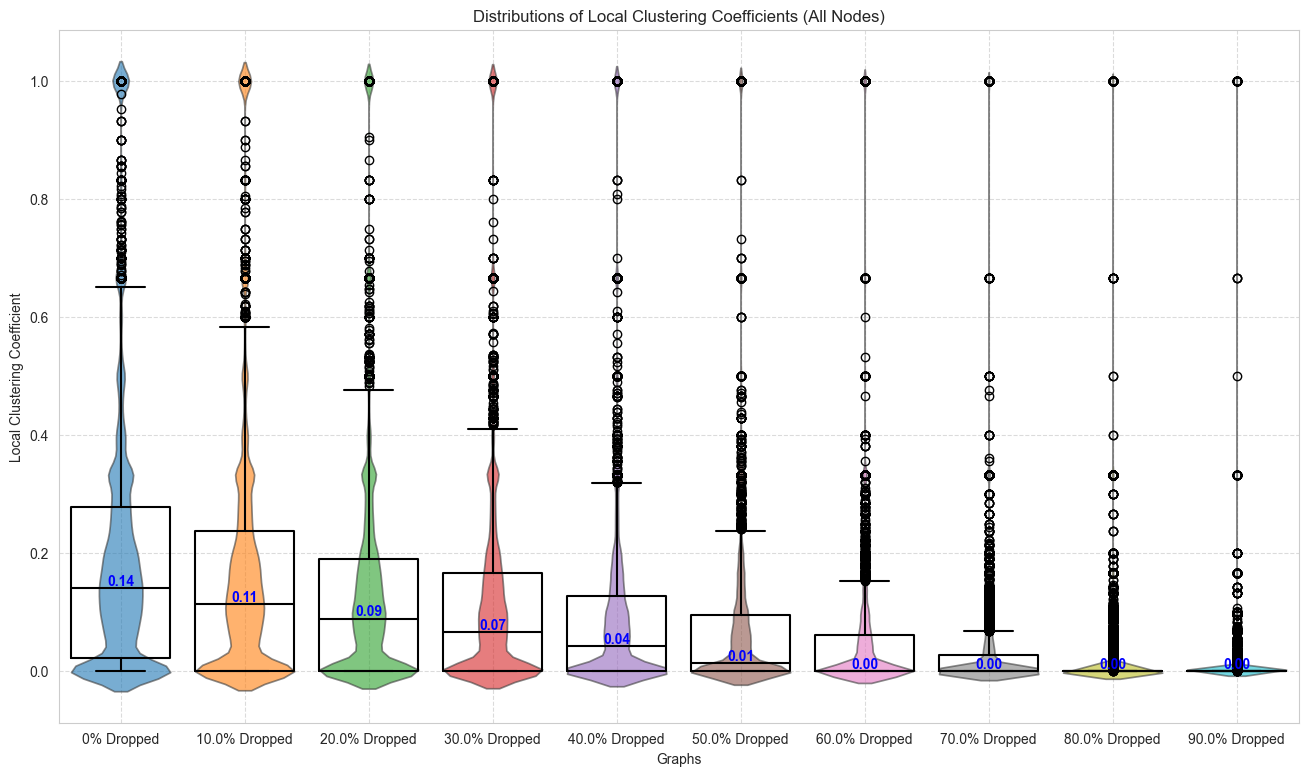

In [11]:
# Plot the distribution by overlaying violin and boxplots (Template generated by ChatGPT)
plt.figure(figsize=(16, 9))
sns.boxplot(data=clustering_df, x="Graph", y="Local Clustering Coefficient", legend=False, fill=False, color='black')
sns.violinplot(data=clustering_df, x="Graph", y="Local Clustering Coefficient", hue='Graph', inner=None, alpha=0.6, legend=False, saturation=1, bw_adjust=0.5)

# Calculate medians and add annotations (ChatGPT)
medians = clustering_df.groupby(['Graph'])['Local Clustering Coefficient'].median().values
for i, median in enumerate(medians):
    plt.text(i, median, f'{median:.2f}', ha='center', va='bottom', color='blue', fontweight='bold')


plt.xlabel("Graphs")
plt.ylabel("Local Clustering Coefficient")
plt.title("Distributions of Local Clustering Coefficients (All Nodes)")
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

In [12]:
neighbor_stats_targeted_proteins = []
for label, graph in zip(labels, ppi_graphs):
    for node in targeted_proteins:
        neighbors = list(nx.neighbors(graph, node))
        
        degrees = [graph.degree(node) for node in neighbors]
        local_clustering_coeffs = nx.clustering(graph, node)
        avg_neighbor_degree = np.mean(degrees) if degrees else 0
        
        node_neighbor_stats = {
            "Graph": label,
            "Node": node,
            "Number of Neighbors": len(neighbors),
            "Local Clustering Coefficient": local_clustering_coeffs,
            "Average Neighbor Degree": avg_neighbor_degree
        }
        
        neighbor_stats_targeted_proteins.append(node_neighbor_stats)
        
neighbor_df = pd.DataFrame(neighbor_stats_targeted_proteins)
        

### Distribution of Local Clustering Coefficients For Targeted Nodes

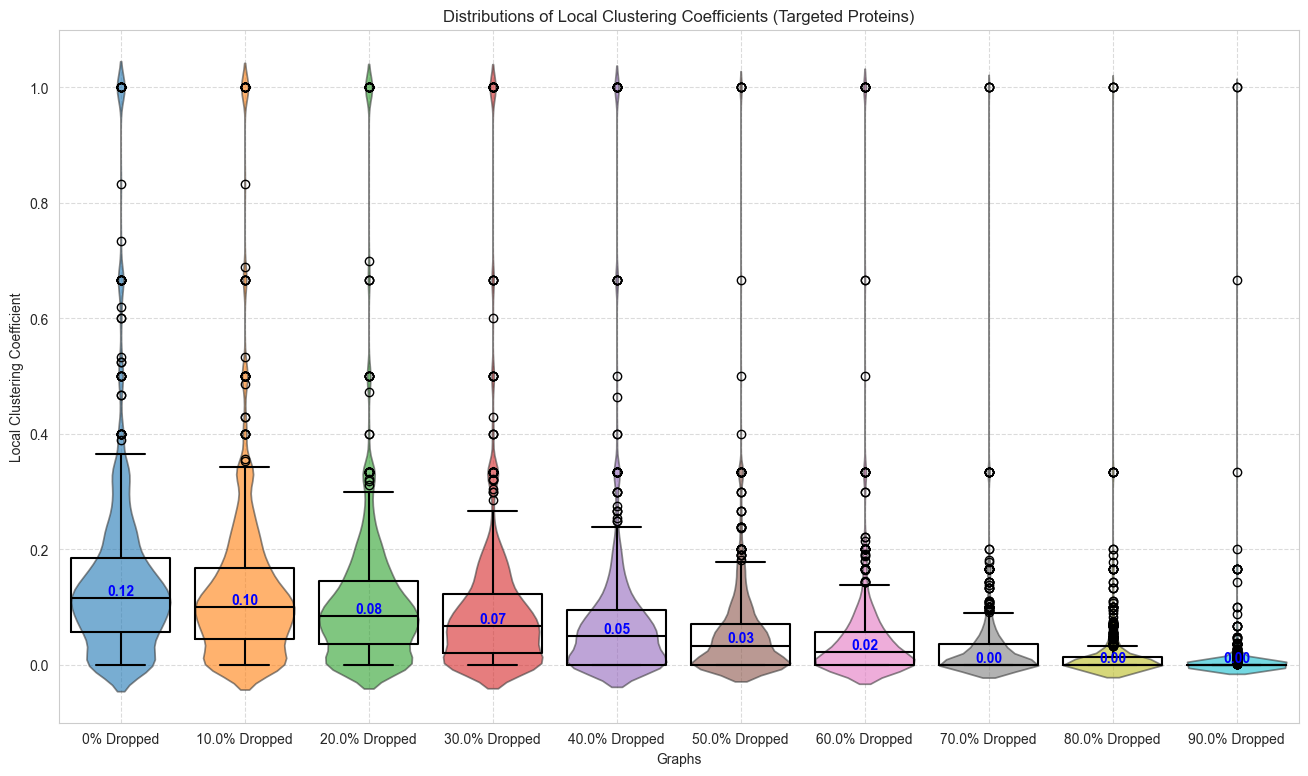

In [13]:
plt.figure(figsize=(16, 9))
sns.boxplot(data=neighbor_df, x="Graph", y="Local Clustering Coefficient", legend=False, fill=False, color='black')
sns.violinplot(data=neighbor_df, x="Graph", y="Local Clustering Coefficient", hue='Graph', inner=None, alpha=0.6, legend=False, saturation=1, bw_adjust=0.5)

# Calculate medians and add annotations (ChatGPT)
medians = neighbor_df.groupby(['Graph'])['Local Clustering Coefficient'].median().values
for i, median in enumerate(medians):
    plt.text(i, median, f'{median:.2f}', ha='center', va='bottom', color='blue', fontweight='bold')


plt.xlabel("Graphs")
plt.ylabel("Local Clustering Coefficient")
plt.title("Distributions of Local Clustering Coefficients (Targeted Proteins)")
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

## Neighbor Information
- In the default configuration the model aggregates information not only from targeted proteins and directly connected proteins but also neighbors of neighbors
- How well-connected the immediate neighbours of the targeted proteins are determines the information that can be aggregated from local protein networks
- Degree of neighbors gives as an idea about how much information the model has access to beyond its immediate vicinity

## Intuition
- Lower Neighbor Degrees means that aggregated information is mostly limited to immediate local interactions, if the drugs affect a wider area of protein interactions it could have difficulties generalizing to those
- Higher Neighbor Degrees means the model has access to information that is located further out in the graph, if clustering is low the model could put an equal emphasis on both local and spread out protein interactions --> Good generalization

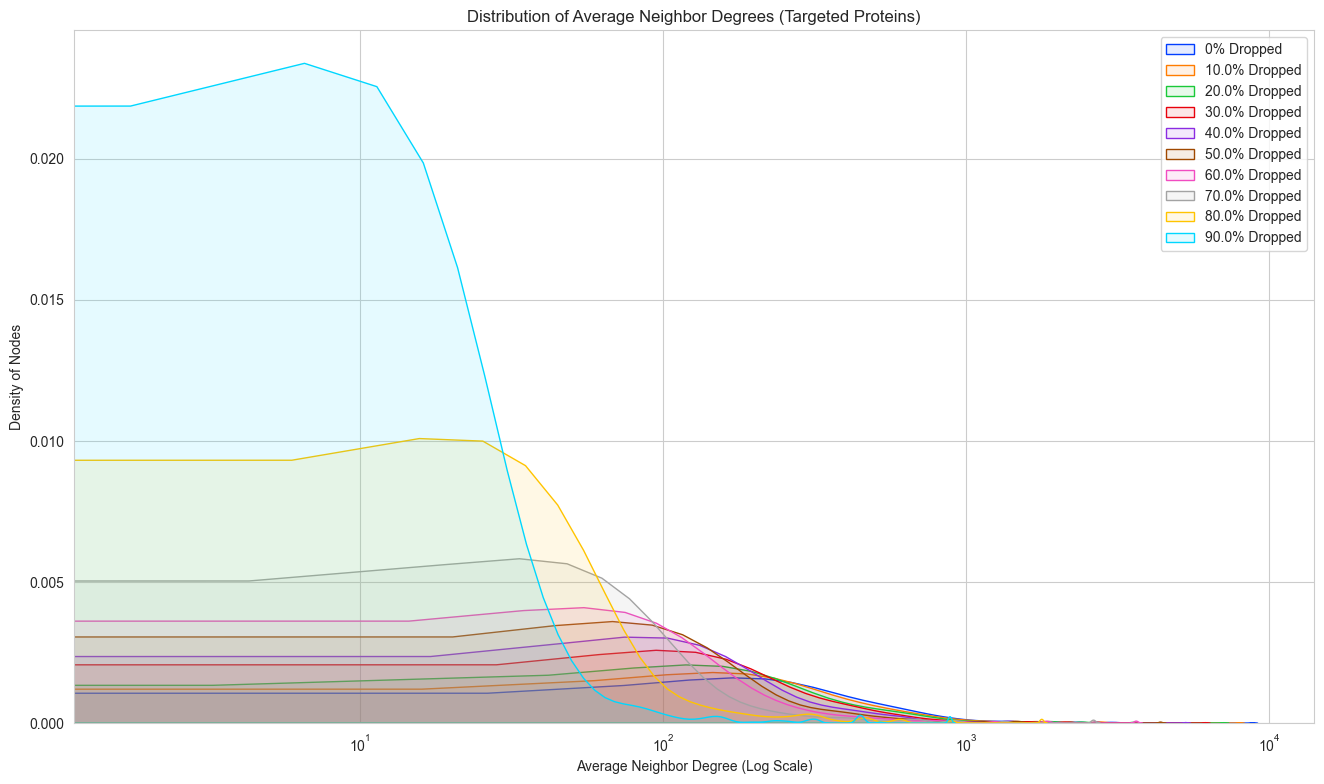

In [14]:
plt.figure(figsize=(16, 9))

for label, color in zip(labels, colors):
    test_df = neighbor_df.loc[neighbor_df['Graph'] == label, ['Average Neighbor Degree']]
    sns.kdeplot(test_df["Average Neighbor Degree"], color=color, label=label, fill = True, alpha=0.1, bw_adjust=0.5)
    
plt.ylabel("Density of Nodes")
plt.xlabel("Average Neighbor Degree (Log Scale)")
plt.xscale('log')
#plt.xlim(-200, 1000)
plt.title("Distribution of Average Neighbor Degrees (Targeted Proteins)")
plt.legend()
plt.show()